In [2]:
!nvidia-smi

Mon Jan 20 14:30:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.26       Driver Version: 430.26       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1D:00.0 Off |                  N/A |
| 30%   42C    P2    55W / 250W |    869MiB / 11019MiB |     11%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1E:00.0 Off |                  N/A |
| 27%   29C    P8     7W / 250W |  10927MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [3]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="7"

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time, datetime

import sys
sys.path.append('/mnt/disk1/project/SMhospital/capsule/ce_packages')
from ce_utils import load_path, train_valid_split, damped_exp_LR, load_random_minibatch, shuffle
from ce_utils import training_history

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

# Load Data

In [4]:
from itertools import product
import glob

def target_preprocessings(phase_a_switch = [1, 1, 1], phase_b_switch = True, mode = 'load'):
    """
    phase_a_switch = [1, 1, 1], [0, 0 ,1], [1, 1, 0].... 
    that means [flip, rotate, blur_sharp]
    """
    phase0 = ['_c']
    phase1 = {1: ['-', 'f'], 0: ['-']}
    phase2 = {1: ['-', 'r1', 'r2', 'r3'], 0: ['-']}
    phase3 = {1: ['-', 'ab', 'mb', 'eh'], 0: ['-']}
    phase4 = ['s_-30_v_30', 's_-30_v_-30', 's_30_v_-30', 's_30_v_30']
    
    if mode == 'load':
        phase_a_items = [phase1[phase_a_switch[0]], phase2[phase_a_switch[1]], phase3[phase_a_switch[2]]]
    elif mode == 'preprocessing':
        phase_a_items = [phase0, phase1[phase_a_switch[0]], phase2[phase_a_switch[1]], phase3[phase_a_switch[2]]]
    
    phase_a = []
    for i in list(product(*phase_a_items)):
        phase_a.append('_'.join(i))

    if not phase_b_switch != True:
        phase_b = []
        for i in list(product(*[phase_a, phase4])):
            phase_b.append('_'.join(i))
        return list(np.hstack([phase_a, phase_b]))
    else:
        return phase_a 

class ce_load_dataset:
    def __init__(self, phase, data, pre_a, pre_b, img_ch = 'bgr', ext_name = True):
        self.phase = phase        # 'train' or 'test'
        self.data = data          # 'sm', 'sm_core', 'sm_v2', 'sm_x160', ...
        self.pre_a = pre_a        # [1, 1, 1], [0, 0 ,1], [1, 1, 0].... 
        self.pre_b = pre_b        # True or False
        self.img_ch = img_ch      # 'bgr', 'rgb', and 'hsv'
        self.ext_name = ext_name  # True or False

    def load_path(self, cls, les, data_dir = '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed'):
        """
        phase = 'train', 'test'
        cls: [les]  
          'n': ['neg']
          'h': ['redspot', 'angio', 'active'], 
          'd': ['ero', 'ulc', 'str'],
          'p': ['amp', 'lym', 'tum']}
        pre_a[0] must be 0
        """
        lesions = dict(neg = 'negative', 
                       redspot = 'red_spot', angio = 'angioectasia', active = 'active_bleeding', 
                       ero = 'erosion', ulcer = 'ulcer', str = 'stricture', 
                       amp = 'ampulla_of_vater', lym = 'lymphoid_follicles', tum = 'small_bowel_tumor')
        classes = dict(n = 'negative', h = 'hemorrhagic', d = 'depressed', p = 'protruded')

        path = os.path.join(data_dir, self.data, self.phase, classes[cls], lesions[les])
        pathlist = glob.glob(path + '/*.jpg')
        if self.pre_b != True:
            path_in_phase = []
            for p in pathlist:
                name = os.path.basename(p)
                if (name.split('c_')[-1])[:-4] in target_preprocessings(self.pre_a, self.pre_b):
                    path_in_phase.append(p)   
            return np.asarray(path_in_phase)
        else:
            return np.asarray(pathlist)

    def load_image_from_path(self, pathlist,image_ch = 'bgr', extract_name = False):
        data = []
        for i in pathlist:
            temp = cv2.imread(i)
            if image_ch == 'bgr':
                pass
            elif image_ch == 'rgb':
                temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
            elif image_ch == 'hsv':
                temp = cv2.cvtColor(temp, cv2.COLOR_BGR2HSV)
            data.append(temp)
        if extract_name != False:
            name = []
            for i in pathlist:
                name.append(os.path.basename(i))
            return np.asarray(data), np.asarray(name)
        else:
            return np.asarray(data) 

    def load_data(self, cls, les):
        pathlist = self.load_path(cls, les)
        return  self.load_image_from_path(pathlist, image_ch = self.img_ch, extract_name = self.ext_name)

In [5]:
ce = ce_load_dataset(phase = 'train', data = 'sm_x160', pre_a = [1, 1, 1], pre_b = False)

In [6]:
neg_path = ce.load_path('n', 'neg')
# redspot_path = ce.load_path('h', 'redspot')
# angio_path = ce.load_path('h', 'angio')
# active_path = ce.load_path('h', 'active')
ero_path = ce.load_path('d', 'ero')
ulcer_path = ce.load_path('d', 'ulcer')
str_path = ce.load_path('d', 'str')

print("negative:",neg_path.shape)
# print("red spot:",redspot_path.shape)
# print("angioectasia:",angio_path.shape)
# print("active_bleeding:",active_path.shape)
print("erosion:",ero_path.shape)
print("ulcer:",ulcer_path.shape)
print("stricture:",str_path.shape)

negative: (203424,)
erosion: (25632,)
ulcer: (24768,)
stricture: (3136,)


In [7]:
neg_path

array(['/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed/sm_x160/train/negative/negative/DJ___01-58-07___1014178__c_-_-_-.jpg',
       '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed/sm_x160/train/negative/negative/DJ___01-58-07___1014178__c_-_-_ab.jpg',
       '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed/sm_x160/train/negative/negative/DJ___01-58-07___1014178__c_-_-_mb.jpg',
       ...,
       '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed/sm_x160/train/negative/negative/희신___02-23-34___2029109__c_f_r3_ab.jpg',
       '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed/sm_x160/train/negative/negative/희신___02-23-34___2029109__c_f_r3_mb.jpg',
       '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed/sm_x160/train/negative/negative/희신___02-23-34___2029109__c_f_r3_eh.jpg'],
      dtype='<U179')

In [8]:
neg_train_path, neg_valid_path = train_valid_split(neg_path)
# redspot_train_path, redspot_valid_path = train_valid_split(redspot_path)
# angio_train_path, angio_valid_path = train_valid_split(angio_path)
# active_train_path, active_valid_path = train_valid_split(active_path)
ero_train_path, ero_valid_path = train_valid_split(ero_path)
ulcer_train_path, ulcer_valid_path = train_valid_split(ulcer_path)
str_train_path, str_valid_path = train_valid_split(str_path)

print("negative:", neg_train_path.shape, neg_valid_path.shape)
# print("red spot:", redspot_train_path.shape, redspot_valid_path.shape)
# print("angioectasia:", angio_train_path.shape, angio_valid_path.shape)
# print("active bleeding:", active_train_path.shape, active_valid_path.shape)
print("erosion:", ero_train_path.shape, ero_valid_path.shape)
print("ulcer:", ulcer_train_path.shape, ulcer_valid_path.shape)
print("stricture:", str_train_path.shape, str_valid_path.shape)

negative: (172910,) (25898,)
erosion: (21787,) (3235,)
ulcer: (21052,) (3181,)
stricture: (2665,) (390,)


# Model

In [9]:
input_h = 512
input_w = 512
input_ch = 3

k_chs = [16, 16, 16, 32, 32, 32, 64]
n_conv_block = len(k_chs)
n_hid_node = [100, 50]
n_hid_layer = len(n_hid_node)
n_output = 2

In [10]:
class CE_cnn:
    def __init__(self, k_chs, n_conv_block, n_hid_node, n_hid_layer, n_output):
        self.k_chs = k_chs
        self.n_conv_block = n_conv_block
        self.n_hid_node = n_hid_node
        self.n_hid_layer = n_hid_layer
        self.n_output = n_output
    def conv_block(self, x, k_chs, n_conv_block):
        for i in range(1, n_conv_block + 1):
            if i == 1:
                conv = tf.layers.conv2d(inputs = x, filters = k_chs[i-1], kernel_size = [3, 3], padding = "SAME", 
                                        activation= tf.nn.relu, name = 'block_{}_conv_1'.format(i))
            else:
                conv = tf.layers.conv2d(inputs = conv, filters = k_chs[i-1], kernel_size = [3, 3], padding = "SAME", 
                                        activation= tf.nn.relu, name = 'block_{}_conv_1'.format(i))
            conv = tf.layers.conv2d(inputs = conv, filters = k_chs[i-1], kernel_size = [3, 3], padding = "SAME", 
                                    activation= tf.nn.relu, name = 'block_{}_conv_2'.format(i))
            conv = tf.layers.max_pooling2d(inputs = conv, pool_size = [2, 2], strides = 2, name = 'block_{}_maxp'.format(i))
        return conv
    def fc_layers(self, x, n_hid_node, n_hid_layer, n_output):
        hidden = tf.layers.flatten(x)
        for i in range(1, n_hid_layer + 1):
            hidden = tf.layers.dense(inputs = hidden, units = n_hid_node[i-1],activation = tf.nn.relu, name = 'fc_{}'.format(i))
            hidden = tf.layers.dropout(hidden, rate = 0.3, training = is_training)
        score = tf.layers.dense(inputs = hidden, units = n_output, name = 'score')
        return score
    
    def inf(self, x):
        conv = self.conv_block(x, self.k_chs, self.n_conv_block)
        score = self.fc_layers(conv, self.n_hid_node, self.n_hid_layer, self.n_output)
        return score

In [11]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, [None, input_h, input_w, input_ch], name = 'img')
y = tf.placeholder(tf.float32, [None, n_output], name = 'label')
#rate = tf.placeholder(tf.float32, name = 'rate') # tf.layers.dropout용 얼만큼 드랍아웃할건지
is_training = tf.placeholder(tf.bool, name = 'is_training')
LR = tf.placeholder(tf.float32)

model = CE_cnn(k_chs, n_conv_block, n_hid_node, n_hid_layer, n_output)
score = model.inf(x)
loss = tf.losses.softmax_cross_entropy(onehot_labels=y, logits=score)
loss = tf.reduce_mean(loss)

# update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
# with tf.control_dependencies(update_ops):
#     optm = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)
optm = tf.train.AdamOptimizer(LR).minimize(loss)

saver = tf.train.Saver()
sess = tf.Session()

init = tf.global_variables_initializer()
sess.run(init)

W0120 14:31:15.240573 139912799573760 deprecation.py:323] From <ipython-input-10-147423120551>:12: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0120 14:31:15.246929 139912799573760 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0120 14:31:15.466123 139912799573760 deprecation.py:323] From <ipython-input-10-147423120551>:18: max_pooling2d (from tensorflow.python.layers.pooling) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
W0120 14:31:15.779227 139912799573760 deprecation.py:323]

# Training

damped_exp_LR(40000, alpha = 0.00005) <br>
n_batch (per class) = 50  <br>
cal_interval = 10 <br>
prt_interval = 100 <br>

In [12]:
d_train_path = np.hstack([ero_train_path, ulcer_train_path, str_train_path])
d_valid_path = np.hstack([ero_valid_path, ulcer_valid_path, str_valid_path])

a_train_path = shuffle(d_train_path, None)
a_valid_path = shuffle(d_valid_path, None)

In [13]:
damped_exp_LR

<function ce_utils.damped_exp_LR(n_iter, f=20, A=0.0005, alpha=0.0002, gamma=0.1)>

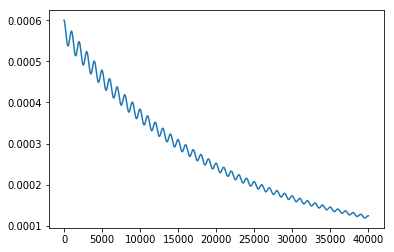

In [14]:
D_lr = damped_exp_LR(40000, alpha = 0.00005)

plt.plot(D_lr)

In [15]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

n_iter = 0
n_batch = 50
cal_interval = 10
prt_interval = 100
 
early_stopping = False
accr_train, accr_valid, loss_train, loss_valid = [], [], [], []
hist = training_history(accr_train, accr_valid, loss_train, loss_valid)
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = n_batch)
    a_train_x, a_train_y = load_random_minibatch(a_train_path, cls = 1, batch_size = n_batch)
    train_x = np.vstack([neg_train_x, a_train_x])
    train_y = np.vstack([neg_train_y, a_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = n_batch)
        a_valid_x, a_valid_y = load_random_minibatch(a_valid_path, cls = 1, batch_size = n_batch)
        valid_x = np.vstack([neg_valid_x, a_valid_x])
        valid_y = np.vstack([neg_valid_y, a_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'X160_frb_ND_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 40000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[## training negative images: 254,280 (x40)-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss


W0120 14:33:24.127595 139912799573760 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/training/saver.py:960: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


[*100] || 70.00 %    || 70.00 %    || 0.57882053 || 0.59383178
--------------------------------------------------------------
[*200] || 90.00 %    || 89.00 %    || 0.24539526 || 0.25757864
--------------------------------------------------------------
[*300] || 90.00 %    || 94.00 %    || 0.18915069 || 0.17741467
--------------------------------------------------------------
[*400] || 92.00 %    || 88.00 %    || 0.20281844 || 0.29454744
--------------------------------------------------------------
[*500] || 92.00 %    || 89.00 %    || 0.20016240 || 0.22068276
--------------------------------------------------------------
[*600] || 88.00 %    || 93.00 %    || 0.30603325 || 0.16026703
--------------------------------------------------------------
[*700] || 92.00 %    || 92.00 %    || 0.21661736 || 0.24897406
--------------------------------------------------------------
[*800] || 90.00 %    || 93.00 %    || 0.23231833 || 0.16322985
-------------------------------------------------------

[6600] || 97.00 %    || 97.00 %    || 0.08759616 || 0.07510420
--------------------------------------------------------------
[6700] || 99.00 %    || 99.00 %    || 0.03693449 || 0.03172131
--------------------------------------------------------------
[6800] || 100.00 %    || 98.00 %    || 0.03260750 || 0.07790875
--------------------------------------------------------------
[6900] || 95.00 %    || 97.00 %    || 0.11935054 || 0.10996804
--------------------------------------------------------------
[7000] || 99.00 %    || 98.00 %    || 0.04343724 || 0.09214386
--------------------------------------------------------------
[7100] || 96.00 %    || 96.00 %    || 0.06936768 || 0.07206728
--------------------------------------------------------------
[7200] || 99.00 %    || 100.00 %    || 0.04605601 || 0.02216365
--------------------------------------------------------------
[7300] || 100.00 %    || 97.00 %    || 0.02624498 || 0.06110692
----------------------------------------------------

KeyboardInterrupt: 

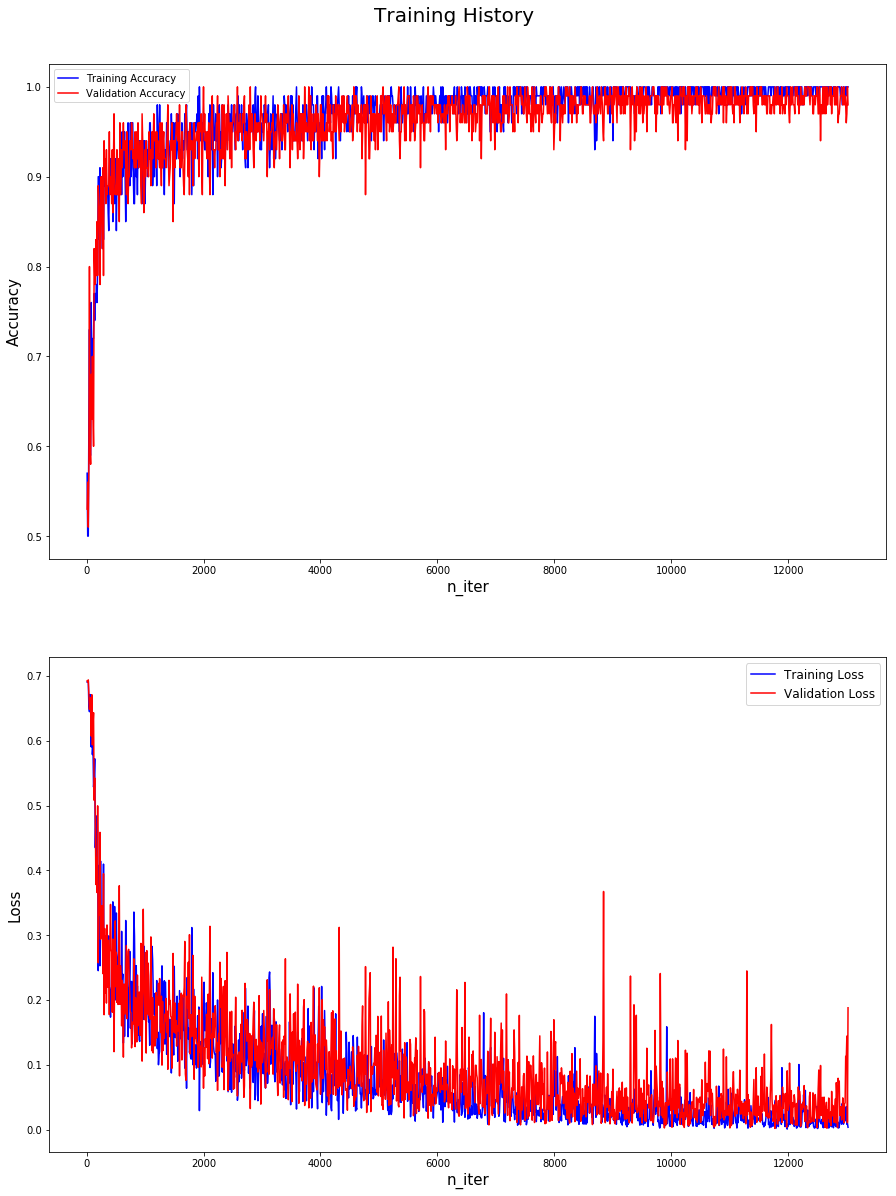

In [37]:
hist.plot(cal_interval)  

In [16]:
def test_batch_idxs(data, batch_size = 250):
    """generate the serial batch of data on index-level.
       Usually, the data is too large to be evaluated at once.
    
    Args:
      data: A list or array of target dataset e.g. data_x we use
      batchsize: A integer
      
    Returns:
      batch_idxs: A list, 
    """
    total_size = len(data)
    batch_idxs = []
    start = 0
    while True:
        if total_size >= start + batch_size:
            batch_idxs.append([start + i for i in range(batch_size)])
        elif total_size < start + batch_size:
            batch_idxs.append([start + i for i in range(total_size - start)])
        start += batch_size
        if total_size <= start:
            break
    return batch_idxs

def batch_flatten(data):
    """flatten A list stacked with the result of batch.
    
    Args:
      data: A list or array  
      
    Returns:
      Data: A list, total result
    """
    batch_n = len(data)
    for i in range(batch_n):
        if i == 0:
            Data = data[i]
        else:
            Data = np.concatenate((Data, data[i]), axis = 0)   
    return Data

In [30]:
a_crop_path = []

for p in a_valid_path:
    name = os.path.basename(p)
    if (name.split('c_')[-1])[:-4] == '-_-_-':
        a_crop_path.append(p)
        
a_crop_path = np.asarray(a_crop_path)

In [31]:
len(a_crop_path)

190

In [34]:
accr_list = []

for i in range(30):
    a_valid_x, a_valid_y = load_random_minibatch(a_crop_path, cls = 1, batch_size = n_batch)
    p = sess.run(score, feed_dict = {'img:0': a_valid_x, 'is_training:0' :0})

    pred = np.argmax(p, axis = 1)
    true = np.argmax(a_valid_y, axis =1)
    
    accr_list.append(np.mean(np.equal(pred, true)))

In [36]:
np.mean(accr_list)

0.9926666666666667

In [38]:
hist.table()

start_time = time.time()

while True:
    neg_train_x, neg_train_y = load_random_minibatch(neg_train_path, cls = 0, batch_size = n_batch)
    a_train_x, a_train_y = load_random_minibatch(a_train_path, cls = 1, batch_size = n_batch)
    train_x = np.vstack([neg_train_x, a_train_x])
    train_y = np.vstack([neg_train_y, a_train_y])
    train_x, train_y = shuffle(train_x, train_y)
    
    sess.run(optm, feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :1, LR: D_lr[n_iter]})
    n_iter += 1
    
    if n_iter % cal_interval == 0:
        c, p = sess.run([loss, score], feed_dict = {'img:0': train_x, 'label:0': train_y, 'is_training:0' :0})

        p = np.argmax(p, axis = 1)
        l = np.argmax(train_y, axis = 1)
        a = np.mean(np.equal(p, l))
        
        neg_valid_x, neg_valid_y = load_random_minibatch(neg_valid_path, cls = 0, batch_size = n_batch)
        a_valid_x, a_valid_y = load_random_minibatch(a_valid_path, cls = 1, batch_size = n_batch)
        valid_x = np.vstack([neg_valid_x, a_valid_x])
        valid_y = np.vstack([neg_valid_y, a_valid_y])
        
        c_valid, p_valid = sess.run([loss, score], feed_dict = {'img:0': valid_x, 'label:0': valid_y, 'is_training:0' :0})

        p_valid = np.argmax(p_valid, axis = 1)
        l_valid = np.argmax(valid_y, axis = 1)
        a_valid = np.mean(np.equal(p_valid, l_valid))

        accr_valid.append(a_valid)
        loss_valid.append(c_valid)
        accr_train.append(a)
        loss_train.append(c)

        if n_iter % prt_interval == 0:
            hist.prt_evl(n_iter)

        if loss_valid[-1] == np.min(loss_valid):
            now = datetime.datetime.now()
            nowDatetime = now.strftime('%y%m%d%H%M')
            model_name = 'X160_frb_ND_{0}_{1}_val_acc_{2:.2f}_val_loss_{3:.6f}'.format(nowDatetime, n_iter, accr_valid[-1], loss_valid[-1])
            saver.save(sess, './model/' + model_name)
        if n_iter == 40000:
            break
#         if n_iter > 5000:
#             if np.max(accr_train) < 0.9:
#                 if np.mean(loss_train[-50:-30]) <= np.mean(loss_train[-30:]) :
#                     hist.early_under(n_iter)
#                     early_stopping = True
#                     break
#             if np.mean(accr_train[## training negative images: 254,280 (x40)-50:]) >= 0.995:
#                 if (
#                     np.mean(loss_valid[-41:-21]) <= np.mean(loss_valid[-21:-1]) and
#                     loss_valid[-1] < loss_valid[-2] # np.min(loss_valid[-20:]) == loss_valid[-1]
#                     ):
#                     hist.early_over(n_iter)
#                     early_stopping = True
#                     break          
    
train_time = int((time.time() - start_time)/60)  
hist.done(n_iter, train_time, early_stopping)

hist.plot(cal_interval)   

# sess.close()

[Iter] || Train_accr || Valid_accr || Train_loss || Valid_loss
[13100] || 99.00 %    || 96.00 %    || 0.01975419 || 0.28902397
--------------------------------------------------------------
[13200] || 100.00 %    || 100.00 %    || 0.00513335 || 0.01195045
--------------------------------------------------------------
[13300] || 100.00 %    || 100.00 %    || 0.00761196 || 0.01125525
--------------------------------------------------------------
[13400] || 99.00 %    || 100.00 %    || 0.02375382 || 0.01554983
--------------------------------------------------------------
[13500] || 100.00 %    || 99.00 %    || 0.00244509 || 0.02196291
--------------------------------------------------------------
[13600] || 100.00 %    || 99.00 %    || 0.00377666 || 0.05378171
--------------------------------------------------------------
[13700] || 100.00 %    || 100.00 %    || 0.00975880 || 0.00942621
--------------------------------------------------------------
[13800] || 99.00 %    || 97.00 %    || 

KeyboardInterrupt: 